In [1]:
import logging
from utils import logging as lg

lg.set_logging()

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import math

from utils import data_provider
from notebook_utils import plot
plot.setup()

2017-10-08 00:58:32,172 | INFO : plot.py(setup 13) - Setup plot parameters


# Data Preparation

In [3]:
X_train, Y_train = data_provider.get_mnist('train', dir_path='../data/mnist')
X_test, Y_test = data_provider.get_mnist('test', dir_path='../data/mnist')

2017-10-08 00:58:32,806 | INFO : data_provider.py(get_mnist 17) - Load MNIST : train
2017-10-08 00:58:33,141 | INFO : data_provider.py(get_mnist 17) - Load MNIST : test


In [4]:
X_train_2d = np.copy(X_train.reshape((-1,28,28)))
X_test_2d = np.copy(X_test.reshape((-1,28,28)))

2017-10-07 21:09:03,787 | INFO : plot.py(show_and_save 20) - save fig to ../figures/nb_figures/mnist-label5-with-cols.png


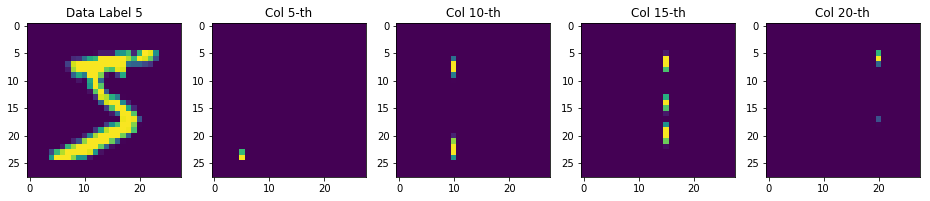

In [11]:
def plot_mnist_with_columns(data_idx, col_indices):
    plt.figure(figsize=(16,3))

    plt.subplot(1,5,1)

    plt.imshow(X_train[data_idx,:].reshape((28,28)))
    plt.title('Data Label %d' % int(np.sum(np.arange(10) * Y_train[data_idx,:])))

    count = 2
    for col_idx in col_indices:
        plt.subplot(1,5,count)
        img_zero = np.zeros((28,28))
        img_zero[:, col_idx] = X_train_2d[data_idx, :, col_idx]
        plt.title('Col %d-th' % col_idx)
        plt.imshow(img_zero, vmin=0, vmax=255)
        count = count + 1
plot_mnist_with_columns(data_idx = 0, col_indices = [5, 10,15,20])
plt.show_and_save(title='mnist-label5-with-cols.png');

In [81]:
def batch_data(x, y, n=1):
    l = len(x)
    for ndx in range(0, l, n):
        yield (x[ndx:min(ndx + n, l)],  y[ndx:min(ndx + n, l)])
        
def build_layer(dims,name):
    weights = tf.Variable(
        tf.truncated_normal(dims, stddev=0.1),
        name="%s_weights"%name
    )

    bias = tf.Variable(
        tf.zeros(dims[1]),
        name="%s_bias"%name
    )
    return weights, bias

# Training

## Network Architecture
![image.png](https://i.imgur.com/icDCONr.png)


### Notations
- $\boldsymbol{x}^{(\alpha)}_{(\cdot,t)}$  : sample $\alpha$ with all rows of column $t \in \{1,\dots, 28\}$
- $\boldsymbol{r}^{(\alpha)}_{t}$ : recurrent inputs of column $t$ of sample $\alpha$
- $\widetilde{\boldsymbol{x}}^{(\alpha)}_{(\cdot,t)}$ : concatenation of $\boldsymbol{x}^{(\alpha)}_{(\cdot,t)}$  and $\boldsymbol{r}_{t}$
- $\boldsymbol{W}_{h}$, $\boldsymbol{b}_{h}$ : weights and bias for hidden unit activations $\boldsymbol{H}^{(\alpha)}_t$
$$
\boldsymbol{H}^{(\alpha)}_t = \text{RELU} \bigg( \widetilde{\boldsymbol{x}}^{(\alpha)}_{(\cdot,t)} \boldsymbol{W}_{h} + \boldsymbol{b}_{h}  \bigg)
$$
- $\boldsymbol{W}_{o}$, $\boldsymbol{b}_{o}$ : weights and bias for output unit activations $\boldsymbol{O}^{(\alpha)}_t$
$$
\boldsymbol{O}^{(\alpha)}_t = \text{RELU} \bigg( \boldsymbol{H}^{(\alpha)}_t \boldsymbol{W}_{o} + \boldsymbol{b}_{o}  \bigg)
$$
- $\boldsymbol{W}_{r}$, $\boldsymbol{b}_{r}$ : weights and bias for recurrent unit activations $\boldsymbol{r}^{(\alpha)}_{t+1}$
$$
\boldsymbol{r}^{(\alpha)}_{t+1} = \text{RELU} \bigg( \boldsymbol{H}^{(\alpha)}_t \boldsymbol{W}_{r} + \boldsymbol{b}_{r}  \bigg)
$$
- $\hat{\boldsymbol{y}}^{(\alpha)}$ : class predictions of $\boldsymbol{x}^{(\alpha)}$
$$
\hat{\boldsymbol{y}}^{(\alpha)} = \text{SOFTMAX} \bigg( \boldsymbol{O}^{(\alpha)}_{28}  \bigg) 
$$

## Training Parameters

In [162]:
# These parameters are choosed arbitrarily.
NETWORK_PARAMS = {
    'batch_size': 50,
    'pior_cell_layer_units': 100,
#     'pior_output_units': 300,
    'hidden_units': 60,
    'output_units': 10,
    'recurrent_units': 7,
    'input_max_seq_length': 28,
    'input_dims': 28,
    'learning_rate': 0.01,
}

## Implementation

In [ ]:
def train_and_evaluate(seq_length=1, epoch=2, _lr=NETWORK_PARAMS['learning_rate'], debug=False):
    no_input_cols = NETWORK_PARAMS['input_max_seq_length'] // seq_length
    logging.info('Training %d columns at a time' % no_input_cols)

    recurrent_inputs = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['recurrent_units']))


    input_weights, input_bias = build_layer((NETWORK_PARAMS['input_dims']*no_input_cols, NETWORK_PARAMS['pior_cell_layer_units']), 'input')
    input_tc_weights, input_tc_bias = build_layer((NETWORK_PARAMS['pior_cell_layer_units'] +NETWORK_PARAMS['recurrent_units'] , NETWORK_PARAMS['hidden_units']), 'input_tc')
    
    output_weights, output_bias = build_layer((NETWORK_PARAMS['hidden_units'], NETWORK_PARAMS['output_units']), 'output')
    
    recurrent_output_weights, recurrent_output_bias = build_layer((NETWORK_PARAMS['hidden_units'], NETWORK_PARAMS['recurrent_units']), 'recurrent')


    x_input = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['input_dims'], NETWORK_PARAMS['input_dims']))
    y_ = tf.placeholder(tf.float32, [None, 10])

    rr = recurrent_inputs
    

    for i in range(0, x_input.shape[1], no_input_cols):
        ii = tf.reshape(x_input[:,i:i+no_input_cols], [-1, no_input_cols * NETWORK_PARAMS['input_dims'] ])
        print(ii.shape)
        itc = tf.nn.relu(tf.matmul(ii, input_weights) + input_bias)
        
        xr = tf.concat([itc, rr], axis=1)
        ha = tf.nn.relu(tf.matmul(xr, input_tc_weights) + input_tc_bias)
        ot = tf.matmul(ha, output_weights) + output_bias
        rr = tf.nn.relu(tf.matmul(ha, recurrent_output_weights) + recurrent_output_bias)

    y = ot

    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

    train_op = tf.train.AdamOptimizer(learning_rate=_lr).minimize(loss_op)

    init_op = tf.global_variables_initializer()

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    with tf.Session() as sess:
        sess.run(init_op)

        step = 1
        for i in range(epoch):
            logging.info('epoch %d' % (i+1))
            for xf, yf in batch_data(X_train_2d, Y_train, n=NETWORK_PARAMS['batch_size']):
        
                rr = np.zeros((NETWORK_PARAMS['batch_size'], NETWORK_PARAMS['recurrent_units']))
                sess.run(train_op, feed_dict={x_input: xf, y_: yf, recurrent_inputs: rr})
                
                if (step % 500 == 0 or step < 10) and debug:
                    rr = np.zeros((len(yf), NETWORK_PARAMS['recurrent_units']))
                    acc, loss = sess.run([accuracy, loss_op], feed_dict={x_input: xf, y_: yf, recurrent_inputs:rr})
                    logging.info('step %d : train acc %f, loss %f' % (step, acc, loss))
                    
                step = step + 1
                
        rr = np.zeros((len(mnist.test.labels), NETWORK_PARAMS['recurrent_units']))
        acc = sess.run(accuracy, feed_dict={x_input: X_test_2d, y_: Y_test, recurrent_inputs: rr})
        print('Seq Length %d (%d epoch trained): Test acc %f' % (seq_length, epoch, acc))
        return acc
    
train_and_evaluate(seq_length=7, epoch=5)

2017-10-08 22:35:06,213 | INFO : <ipython-input-172-fff692566896>(train_and_evaluate 3) - Training 4 columns at a time


(?, 112)
(?, 112)
(?, 112)
(?, 112)
(?, 112)
(?, 112)
(?, 112)


2017-10-08 22:35:30,046 | INFO : <ipython-input-172-fff692566896>(train_and_evaluate 48) - epoch 1


In [170]:
train_and_evaluate(seq_length=7, epoch=10, debug=True)

2017-10-08 13:23:35,668 | INFO : <ipython-input-168-b606a74ff083>(train_and_evaluate 3) - Training 4 columns at a time
2017-10-08 13:23:53,470 | INFO : <ipython-input-168-b606a74ff083>(train_and_evaluate 47) - epoch 1
2017-10-08 13:23:54,028 | INFO : <ipython-input-168-b606a74ff083>(train_and_evaluate 56) - step 1 : train acc 0.360000, loss 2.263072
2017-10-08 13:23:54,035 | INFO : <ipython-input-168-b606a74ff083>(train_and_evaluate 56) - step 2 : train acc 0.300000, loss 2.230270
2017-10-08 13:23:54,042 | INFO : <ipython-input-168-b606a74ff083>(train_and_evaluate 56) - step 3 : train acc 0.300000, loss 2.240301
2017-10-08 13:23:54,048 | INFO : <ipython-input-168-b606a74ff083>(train_and_evaluate 56) - step 4 : train acc 0.200000, loss 2.182860
2017-10-08 13:23:54,055 | INFO : <ipython-input-168-b606a74ff083>(train_and_evaluate 56) - step 5 : train acc 0.320000, loss 2.166144
2017-10-08 13:23:54,062 | INFO : <ipython-input-168-b606a74ff083>(train_and_evaluate 56) - step 6 : train acc 0.

Seq Length 7 (10 epoch trained): Test acc 0.901500


0.90149999

In [ ]:
# no_runs = 10
# accs = []
# for i in range(no_runs):
#     logging.info('Run %d' % (i+1))
#     acc = train_and_evaluate()
#     accs.append(acc)

In [69]:
# print('Average accuracy over %d runs : %.2f±%.2f' % (no_runs, np.mean(accs), np.std(accs)))
# print('max acc: %.2f' % np.max(accs))
# print('min acc: %.2f' % np.min(accs))

Average accuracy over 10 runs : 0.10±0.01
max acc: 0.11
min acc: 0.09


# Feed k columns at a time

In [21]:
# def train_and_evaluate_network2(_lr=0.01, seq_lenghinput_dims=28, recurrent_units=7, output_units=10, hidden_units=100):
#     recurrent_inputs = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['recurrent_units']))

#     input_weights = tf.Variable(
#         tf.truncated_normal(
#             (
#              NETWORK_PARAMS['input_dims'] + NETWORK_PARAMS['recurrent_units'],
#              NETWORK_PARAMS['hidden_units']
#             ),
#             stddev=0.1
#         ),
#         name="input_weights"
#     )

#     input_bias = tf.Variable(
#         tf.zeros(
#             (
#              NETWORK_PARAMS['hidden_units']
#             ),
#         ),
#         name="input_bias"
#     )

#     output_weights = tf.Variable(
#         tf.truncated_normal(
#             (NETWORK_PARAMS['hidden_units'], NETWORK_PARAMS['output_units']),
#             stddev=0.1
#         ),
#         name="output_weights"
#     )

#     output_bias = tf.Variable(
#         tf.zeros(
#             (
#              NETWORK_PARAMS['output_units']
#             ),
#         ),
#         name="output_bias"
#     )

#     recurrent_output_weights = tf.Variable(
#         tf.truncated_normal(
#             (NETWORK_PARAMS['hidden_units'], NETWORK_PARAMS['recurrent_units']),
#             stddev=0.1
#         ),
#         name="recurrent_output_weights"
#     )

#     recurrent_output_bias = tf.Variable(
#         tf.zeros(
#             (
#              NETWORK_PARAMS['recurrent_units']
#             ),
#         ),
#         name="recurrent_output_bias"
#     )

#     x_input = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['input_dims'], NETWORK_PARAMS['input_dims']))
#     y_ = tf.placeholder(tf.float32, [None, 10])

#     rr = recurrent_inputs
#     for i in range(NETWORK_PARAMS['input_seq_length']):
#         xr = tf.concat([ x_input[:,i], rr], axis=1)
#         ha = tf.nn.relu(tf.matmul(xr, input_weights) + input_bias)
#         ot = tf.nn.relu(tf.matmul(ha, output_weights) + output_bias)
#         rr = tf.nn.relu(tf.matmul(ha, recurrent_output_weights) + recurrent_output_bias)

#     y = tf.nn.softmax(ot)

#     cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
#     train_step = tf.train.AdamOptimizer(learning_rate=_lr).minimize(cross_entropy)

#     init_op = tf.global_variables_initializer()

#     with tf.Session() as sess:
#         sess.run(init_op)

#         for i in range(NETWORK_PARAMS['train_epochs']):
#             logging.info('epoch %d' % i)
#             for xf, yf in batch_data(X_train_2d, Y_train, n=NETWORK_PARAMS['batch_size']):
#                 rr = np.zeros((NETWORK_PARAMS['batch_size'], NETWORK_PARAMS['recurrent_units']))
#                 train_step.run(feed_dict={x_input: xf, y_: yf, recurrent_inputs: rr})

#         correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
#         accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#         rr = np.zeros((len(Y_test), NETWORK_PARAMS['recurrent_units']))

#         acc = accuracy.eval(feed_dict={x_input: X_test_2d, y_: Y_test, recurrent_inputs: rr})
#         logging.info('Accuracy %.2f%%' % (acc*100))
#     return acc

1.0

In [44]:
total = 28
seq_length = 7
no_col = total // seq_length

for i in range(0, total, no_col):
    print(i, i + no_col)
# print(no_col)

0 4
4 8
8 12
12 16
16 20
20 24
24 28


In [90]:
Y_train[0,:]

array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.])

In [35]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../data/mnist", one_hot=True)

Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


In [31]:
def build_layer(dims,name):
    weights = tf.Variable(
        tf.truncated_normal(dims, stddev=0.1),
        name="%s_weights"%name
    )

    bias = tf.Variable(
        tf.zeros(dims[1]),
        name="%s_bias"%name
    )
    return weights, bias

In [56]:
def simple_relu_net():
    learning_rate=0.1
    x_input = tf.placeholder(tf.float32, shape=(None, NETWORK_PARAMS['input_dims']*NETWORK_PARAMS['input_dims']))
    y_ = tf.placeholder(tf.float32, [None, 10])

    l1_w, l1_b = build_layer((784,256), 'l1')
    lx_w, lx_b = build_layer((256,256), 'lx')
    l2_w, l2_b = build_layer((256,10), 'l2')
    
    mt = tf.nn.relu(tf.matmul(x_input, l1_w) + l1_b )
    gg = tf.nn.relu(tf.matmul(mt, lx_w) + lx_b )
    ot = tf.matmul(gg, l2_w) + l2_b
     
    y = ot

    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        for i in range(500):
            batch = mnist.train.next_batch(128)
            
            sess.run(train_op, feed_dict={x_input: batch[0], y_: batch[1]})
            
            if i % 100 == 0 or i == 1:
                
                acc, loss = sess.run([accuracy, loss_op], feed_dict={x_input: batch[0], y_: batch[1]})
                print('Loss %f, training acc %f)' %(loss, acc))
#                 print("Train Accuracy : %.4f" % sess.run(accuracy, feed_dict={x_input: X_train_2d.reshape(-1,28*28), y_: Y_train}))
#                 print("Train Accuracy : %.4f" % sess.run(accuracy, feed_dict={x_input: mnist.train.images, y_: mnist.train.labels}))
        print('Test acc %f' % sess.run(accuracy, feed_dict={x_input: mnist.test.images, y_: mnist.test.labels}))
simple_relu_net()

Loss 208.603729, training acc 0.109375)
Loss 91.194565, training acc 0.343750)
Loss 1.995476, training acc 0.226562)
Loss 1.843038, training acc 0.312500)
Loss 1.825322, training acc 0.257812)
Loss 1.618306, training acc 0.375000)
Test acc 0.340300


In [ ]:
# bug!
def batch_data(x, y, n=1):
    l = len(x)
    for ndx in range(0, l, n):
        yield (x[ndx:min(ndx + n, l)],  y[ndx:min(ndx + n, l)])

In [25]:
a = [1,2,3,4,5,6]
b = [-1,-2,-3,-4,-5,-6]

for i,j in batch_data(X_train_2d, Y_train, n=100):
    print(i[0,:])
    break

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

In [30]:
mnist.train.next_batch(100)[0][0,:].reshape(28,28)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.    